# Simulações de Monte Carlo Para o Movimento do Preço de Ações
Este projeto pretende simular o possível movimento dos preços de ações usando o método de Monte carlo.
Apesar de ser uma estimativa simplista que não considera fatores como o valuation, sentimento e fatores econômicos, podemos utilizar de simulações com processos estocástico para descrever a incerteza de curto prazo.

Este projeto está dividido em:
- Base teórica.
- Simulação.
- Resultados.





# Base teórica
O método de ***Monte Carlo*** é uma técnica estatística usada para estimar o comportamento futuro de variáveis incertas, como preços de ativos financeiros. Ele envolve a simulação de várias trajetórias possíveis para essas variáveis com base em distribuições de probabilidade. Esse método é amplamente utilizado para simular trajetórias futuras do preço de um ativo, baseado em um processo estocástico com parâmetros previamente estimados.

O método de Monte Carlo pode ser empregado para estimar o retorno discreto de uma ação com base em um processo de **Wiener** (Um Processo Markoviano específico) com lema de Itô, descrito da seguinte forma:

$$
\ln S_{t+\Delta_t} - \ln S_{t} = \left(r - \frac{1}{2} \sigma^2\right) \cdot \Delta_t + \sigma \cdot \sqrt{\Delta_t} \cdot Z
$$

Essa equação modela o log-retorno do preço da ação, onde $S_t$ é o preço atual do ativo, $r$ é a taxa de retorno média e $\sigma$ é a volatilidade. Utilizando essa expressão, podemos obter o preço futuro da ação ($S_{t+\Delta_t}$) como:

$$
S_{t+\Delta_t} = S_t \cdot e^{\left(r - \frac{1}{2} \sigma^2\right) \cdot \Delta_t + \sigma \cdot \sqrt{\Delta_t} \cdot Z}
$$

Onde:
- $S_t$: Preço do ativo no tempo $t$
- $r$: Taxa de retorno média do ativo
- $\sigma$: Volatilidade do ativo
- $\Delta_t$: Intervalo de tempo
- $Z$: Variável aleatória que segue a distribuição $Z \sim \mathcal{N}(0,1)$ e simula o choque estocástico

De forma simples, esse processo considera que o preço de hoje ($S_{t+\Delta_t}$) é o preço de ontem ($S_t$), ajustado pela taxa de retorno esperada e um choque aleatório representado por $Z$. O termo $\left(r - \frac{1}{2} \sigma^2\right)$ reflete o retorno médio ajustado pela volatilidade, enquanto o termo $\sigma \cdot \sqrt{\Delta_t} \cdot Z$ introduz a aleatoriedade no processo.

Assim, com o método de Monte Carlo podemos criar um grande número de trajetórias aleatórias, que seguiram o processo de Weiner, para analisar estatisticamente o conjunto de possíveis trajetórias. A analíse estatistica das simulações se torna robusta pelo efeito da **Lei dos Grandes Números** que afirma que quanto maior o número de repetições de um experimento, mais próximo o valor médio dos resultados fica do valor real da probabilidade, mas esse é um tema para outro estudo.

Ao utilizar o processo de Weiner se tem como premissa a **Hipótese do Mercado Eficiente** (HME) que tem limitações e não representa todas as caracteristicas do comportamento dos mercado como:

- Caminho Aleatório: Os preços seguem um caminho aleatório, então o histórico não ajuda a prever o futuro.
- Subestimação de Eventos Extremos: O modelo tende a ignorar grandes flutuações de mercado, como crises.
- Desconsidera Comportamentos Humanos: O impacto de fatores psicológicos e irracionais no mercado não é capturado.
- Volatilidade Constante: Assume que a volatilidade não muda ao longo do tempo, o que não reflete a realidade.
- Informação Pública Completa: O modelo pressupõe que todas as informações são conhecidas e refletidas no preço, o que nem sempre acontece.

Referências:
- Molero Pereira, Leonel; Morato Mello, Eduardo. Derivativos ; Negociação e precificação 2º edição (Portuguese Edition) (p. 261). Saint Paul Editora.
- https://pt.wikipedia.org/wiki/Processo_de_Wiener#:~:text=O%20processo%20de%20Wiener%20tem,de%20Langevin%20e%20Fokker%2DPlanck.

## Coleta, tratamento de dados.

A fonte dos dados será Yahoo Finance.
Simulações serão feitas com os preços de fechamento da Nvidia entre 01/01/2020 e 01/10/2024

In [2]:
# Importando bibliiotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Personalizando figuras da Matplotlib
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = 'w'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelcolor'] = 'w'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.autolimit_mode'] = 'data'
plt.rcParams['axes.axisbelow'] = True
import yfinance as yf

[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'Evolução NVDA')

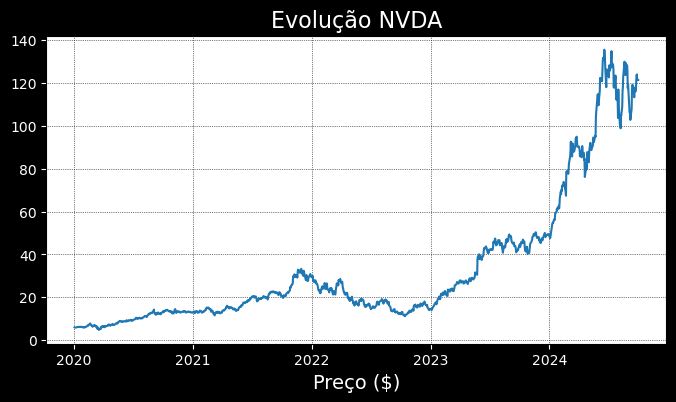

In [3]:
#Coletando dados
TICKER = 'NVDA' #ticker que será feita a simulação.
df_prices = yf.download(TICKER,start='2020-01-01',end='2024-10-01')['Adj Close']
df_prices = pd.DataFrame(np.array(df_prices),index=df_prices.index,columns=[TICKER])
df_prices.dropna(inplace=True)
df_prices.reset_index(inplace=True)
plt.figure(figsize=(8,4))
plt.plot(df_prices['Date'],df_prices[TICKER])
plt.xlabel('Preço ($)')
plt.grid()
plt.title(f'Evolução {TICKER}')


# Simulação
Simulações de Monte Carlo para processo de Weiner.

In [4]:
def fn_monte_carlo(prices, N_steps, N_simulations):
    prices = np.array(prices) # Input - Preços das açoes no formato Pandas_Series
    log_returns = np.log(prices[1:] / prices[:-1]) # Calculo dos Log returns
    len_index = len(prices)
    r =  np.mean(log_returns) # Média dos retornos diários
    sigma = np.std(log_returns) # Volatilidade (desvio padrão dos retornos) 
    S0 = prices[-1]  # Último preço da série
    dt = 1 # Incremento de tempo - na mesma base dos retornos e volatilidade
    
    # Simular múltiplas trajetórias de preços futuros
    future_prices = np.zeros((N_steps + 1, N_simulations)) # Base para armazenar o resultado da simulação no dia t
    future_prices[0] = S0
    
    for t in range(1, N_steps + 1):
        # Gerando vetor de valores randomicos com dimensão 1 x N_simulations
        Z = np.random.standard_normal(N_simulations)
        # Armazena o resultado de N_simulations no passo "t" até N_steps
        future_prices[t] = future_prices[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z) 
    
    return S0, r, sigma, len_index, future_prices


In [5]:
N_STEPS = 30 # Número de dias a frente
N_SIMULATIONS = 10000 # Número de simulações
S0,r,sigma,len_index,temp_prices = fn_monte_carlo(df_prices[TICKER],N_steps=N_STEPS,N_simulations=N_SIMULATIONS,)
predicts = pd.DataFrame(temp_prices, index=np.arange(len_index - 1, len_index + N_STEPS))
predicts_ret = pd.DataFrame(((predicts.iloc[-1])/df_prices[TICKER].iloc[-1] -1).values * 100,index=np.arange(0,N_SIMULATIONS),columns=['Returns'])


Intervalo de confiança de 95% para preço após 30 dias

In [6]:
CONFI_LEVEL = 0.95
lower_bound = np.percentile(predicts.tail(1),100*(1-CONFI_LEVEL)/2) # Intervalo inferior
upper_bound = np.percentile(predicts.tail(1),100*(1-(1-CONFI_LEVEL)/2)) # Intervalo superior
var = np.percentile(predicts_ret['Returns'],1) # Value at Risk para 30 dias

# Resultados
Apresentando resutados das simulações

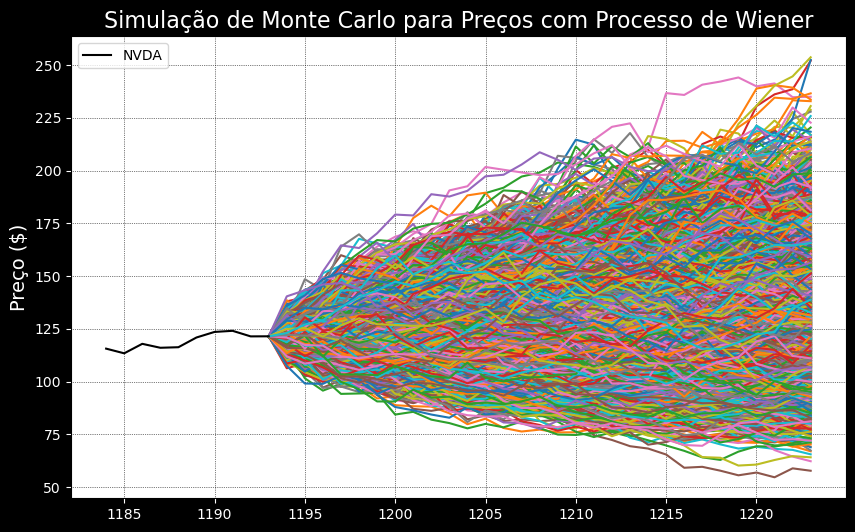

inputs da simulação para NVDA - 30 dias a frente
Preço inicial : 121.44000244140625
Média dos retornos utilizada como entrada:0.25249% (base diária)
Volatilidade diária utilizada como entrada: 0.034


In [12]:
# Criando figura para visualizar simulações
plt.figure(figsize=(10, 6))
plt.plot(predicts.index,predicts, lw=1.5)
plt.plot(df_prices[TICKER].tail(10).index,df_prices[TICKER].tail(10),color='black',label=TICKER)
# Personalizando
plt.title('Simulação de Monte Carlo para Preços com Processo de Wiener',size=16)
plt.ylabel('Preço ($)')
plt.legend()
plt.grid(True)
plt.savefig('Charts/Monte_Carlo_Stock_Predictions.png')
plt.show()
# Print dos dados de entrada
print(f'inputs da simulação para {TICKER} - 30 dias a frente')
print(f'Preço inicial : {df_prices.tail(1)[TICKER].values[0]}')
print(f'Média dos retornos utilizada como entrada:{np.round(r*100,5)}% (base diária)')
print(f'Volatilidade diária utilizada como entrada: {np.round(sigma,3)}')

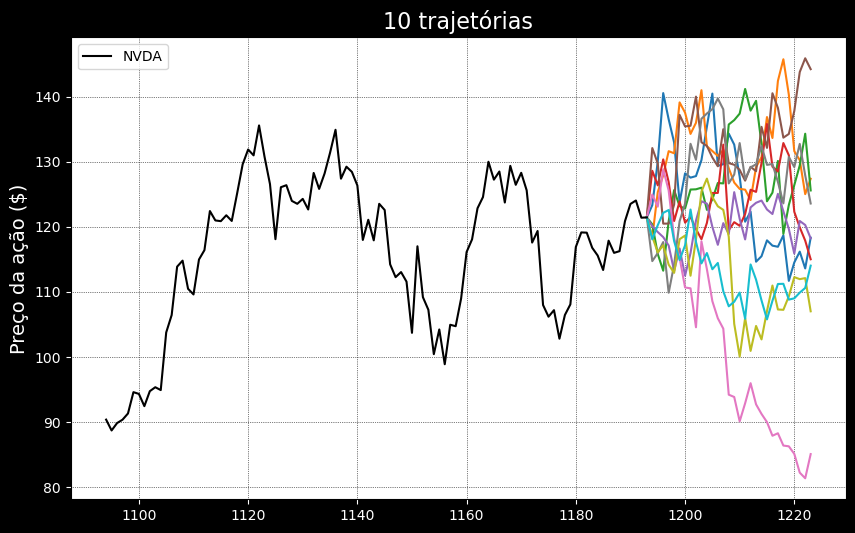

In [8]:
# Visuzalização com menor número de trajetórias simuladas para compreensão do método de Monte Carlo
plt.figure(figsize=(10, 6))
plt.plot(predicts.index,predicts[np.arange(1000,1010)], lw=1.5)
plt.plot(df_prices[TICKER].tail(100).index,df_prices[TICKER].tail(100),color='black',label=TICKER)
plt.title('10 trajetórias', size =16)
plt.ylabel('Preço da ação ($)')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


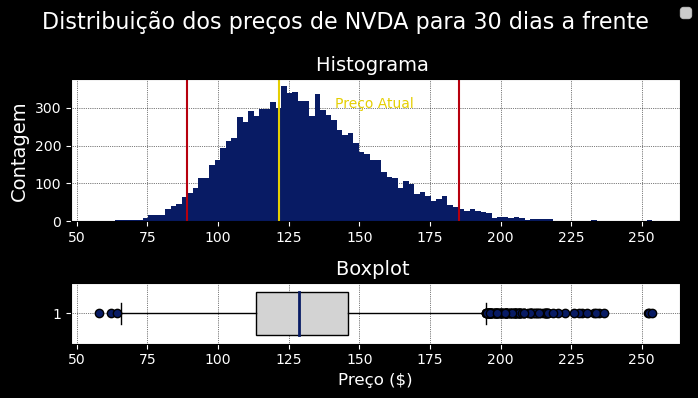

In [9]:
# Criando Figura
# Figura 1
plt.subplots(2, 1, figsize=(7, 4), gridspec_kw={'height_ratios': [7,3]})
plt.subplot(211)
plt.hist(np.array(predicts.iloc[-1]),bins=100,color='#081b64')
plt.ylabel('Contagem')
plt.axvline(x=lower_bound,color='#b7000e')
plt.axvline(x=upper_bound,color='#b7000e')
plt.axvline(x=S0,color='#e5cf03')
plt.annotate('Preço Atual',xy=(S0+20,300),color = '#e5cf03' )
plt.grid()
plt.title(f'Histograma ',color='White',size=14)
# Figura 2
plt.subplot(212)
plt.boxplot(np.array(predicts.iloc[-1]), vert=False,
widths=0.7,
patch_artist=True, 
boxprops=dict(facecolor='lightgray', color='black', linewidth=1),
medianprops=dict(color='#081b64', linewidth=2),
whiskerprops=dict(color='black'),
capprops=dict(color='black'),
flierprops=dict(markerfacecolor='#081b64', marker='o')) 
plt.title(f'Boxplot ',color='White',size=14)
plt.xlabel('Preço ($)',color='white',size=12)
# Personalizando
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('black')
plt.xticks(color='White')
plt.yticks(color='White')
plt.grid(True)
plt.suptitle(f'Distribuição dos preços de {TICKER} para {N_STEPS} dias a frente',size=16,color='white')
plt.subplots_adjust(hspace=0.45)
plt.figlegend()
plt.tight_layout()
plt.show()

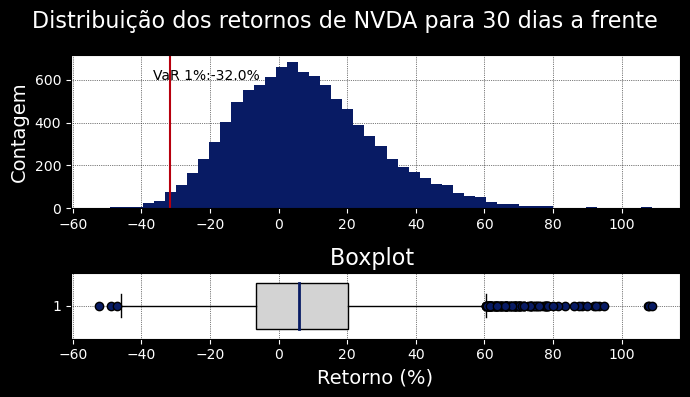

In [10]:
# Criando Figura
# Figura 1
plt.subplots(2, 1, figsize=(7, 4), gridspec_kw={'height_ratios': [7,3]})
plt.subplot(211)
plt.hist(np.array(predicts_ret['Returns']),bins=50,color='#081b64')
plt.ylabel('Contagem')
plt.axvline(x=var,color='#b7000e')
plt.annotate(text=f"VaR 1%:{np.round(var)}%",xy=(var-5,600))
plt.grid()
# Figura 2
plt.subplot(212)
plt.boxplot(np.array(predicts_ret['Returns']), vert=False,
widths=0.7,
patch_artist=True,  # Permite preenchimento
boxprops=dict(facecolor='lightgray', color='black', linewidth=1),
medianprops=dict(color='#081b64', linewidth=2),
whiskerprops=dict(color='black'),
capprops=dict(color='black'),
flierprops=dict(markerfacecolor='#081b64', marker='o')) 
# Personalizando
plt.title(f'Boxplot ',color='White',size=16)
plt.xlabel('Retorno (%)',color='white',size=14)
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('black')
plt.xticks(color='White')
plt.yticks(color='White')
plt.grid(True)
plt.suptitle(f'Distribuição dos retornos de {TICKER} para {N_STEPS} dias a frente',size=16,color='white')
plt.subplots_adjust(hspace=0.45)
plt.tight_layout()
plt.show()

In [11]:
print(f'Resumo dos resultados das previsões para {TICKER} 30 dias a frente utilizando um processo de Weiner')
print(f'Preço inicial : {round(S0,2)}')
print(f'Média dos retornos utilizada como entrada: {round(r,5)*100}% (base diária)')
print(f'Volatilidade diária utilizada como entrada: {round(sigma,3)}')
print(f'Preço Médio das simulações: {round(np.mean(predicts.iloc[-1]),2)}')
print(f'Mediana dos preços das simulações: {np.median(predicts.iloc[-1])}')
print(f'Intervalo de confiança de 95%:[{round(lower_bound,2)} - {round(upper_bound,2)}]')
print(f'Value at Risk das simulações: {round(var,2)}')
print(f'Retorno pela média: {round((np.mean(predicts.iloc[-1])/df_prices[TICKER].iloc[-1] -1) * 100,2)}%')

Resumo dos resultados das previsões para NVDA 30 dias a frente utilizando um processo de Weiner
Preço inicial : 121.44
Média dos retornos utilizada como entrada: 0.252% (base diária)
Volatilidade diária utilizada como entrada: 0.034
Preço Médio das simulações: 130.89
Mediana dos preços das simulações: 128.67626416451242
Intervalo de confiança de 95%:[88.9 - 185.18]
Value at Risk das simulações: -31.68
Retorno pela média: 7.78%
